<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li></ul></li><li><span><a href="#Scenario-1:-continuation-of-lockdown" data-toc-modified-id="Scenario-1:-continuation-of-lockdown-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenario 1: continuation of lockdown</a></span></li><li><span><a href="#Scenario-2:-full-reopening-December-13" data-toc-modified-id="Scenario-2:-full-reopening-December-13-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scenario 2: full reopening December 13</a></span></li><li><span><a href="#Scenario-3:-partial-reopening-November-30" data-toc-modified-id="Scenario-3:-partial-reopening-November-30-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scenario 3: partial reopening November 30</a></span></li><li><span><a href="#Scenario-4:-full-reopening-November-30" data-toc-modified-id="Scenario-4:-full-reopening-November-30-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scenario 4: full reopening November 30</a></span></li><li><span><a href="#Write-out-data" data-toc-modified-id="Write-out-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Write out data</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)


In [5]:
df_google = google.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [6]:
# Load samples dictionary of the first wave
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-13_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp) 

In [7]:
samples_dict.keys()

dict_keys(['beta', 'l', 'tau', 'prevention'])

<IPython.core.display.Javascript object>


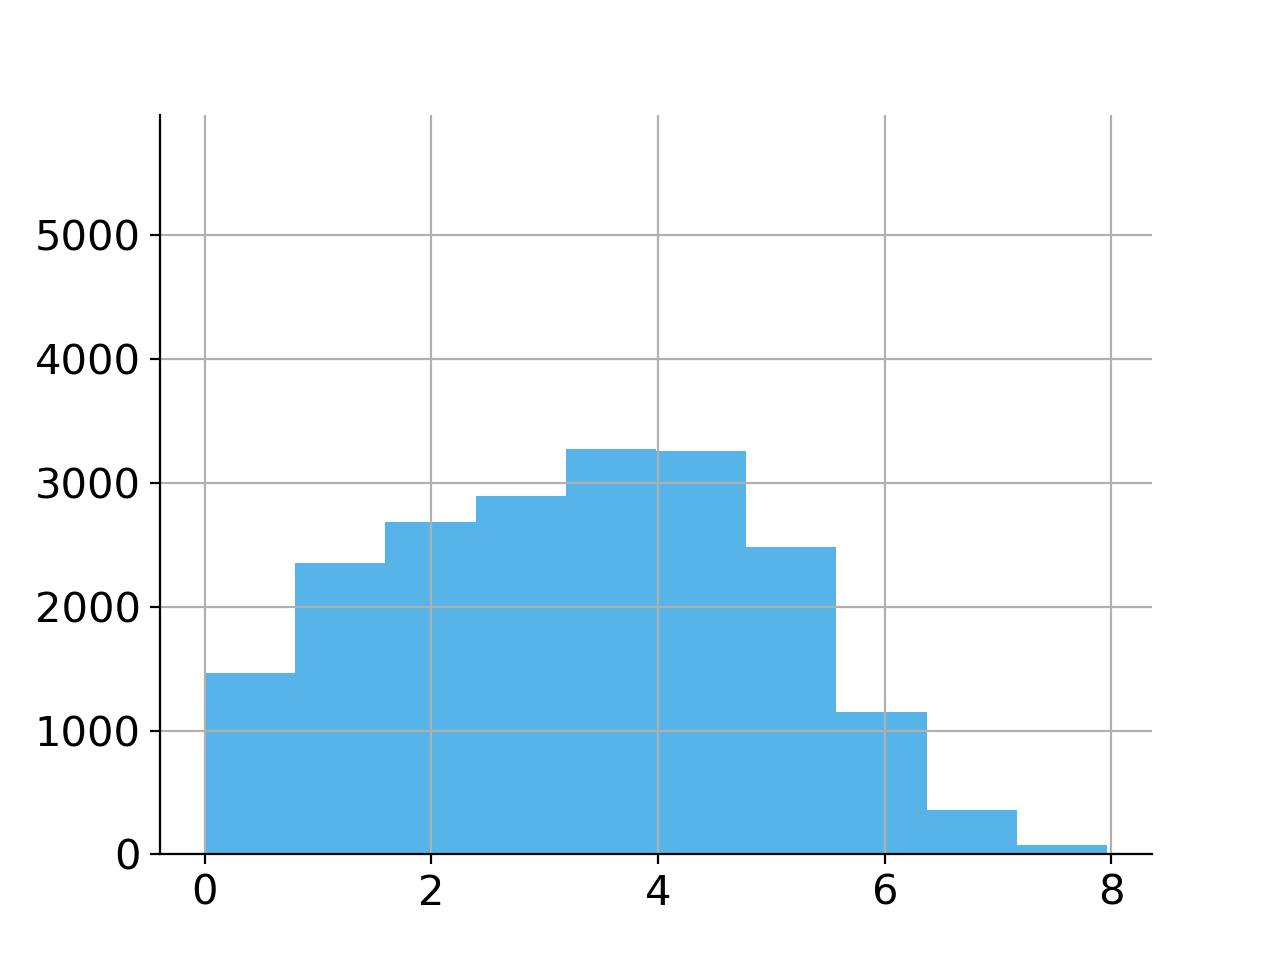

In [8]:
fig,ax = plt.subplots()
pd.Series(samples_dict['beta']).hist()
pd.Series(samples_dict['tau']).hist()

In [9]:
UL = 0.975
LL = 0.025

In [10]:
start_calibration = '2020-09-01'
end_calibration = '2020-11-12'
end_sim = '2021-03-01'

# Scenario 1: continuation of lockdown

In [11]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

# Initialize the model
model_S1 = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown})

<IPython.core.display.Javascript object>


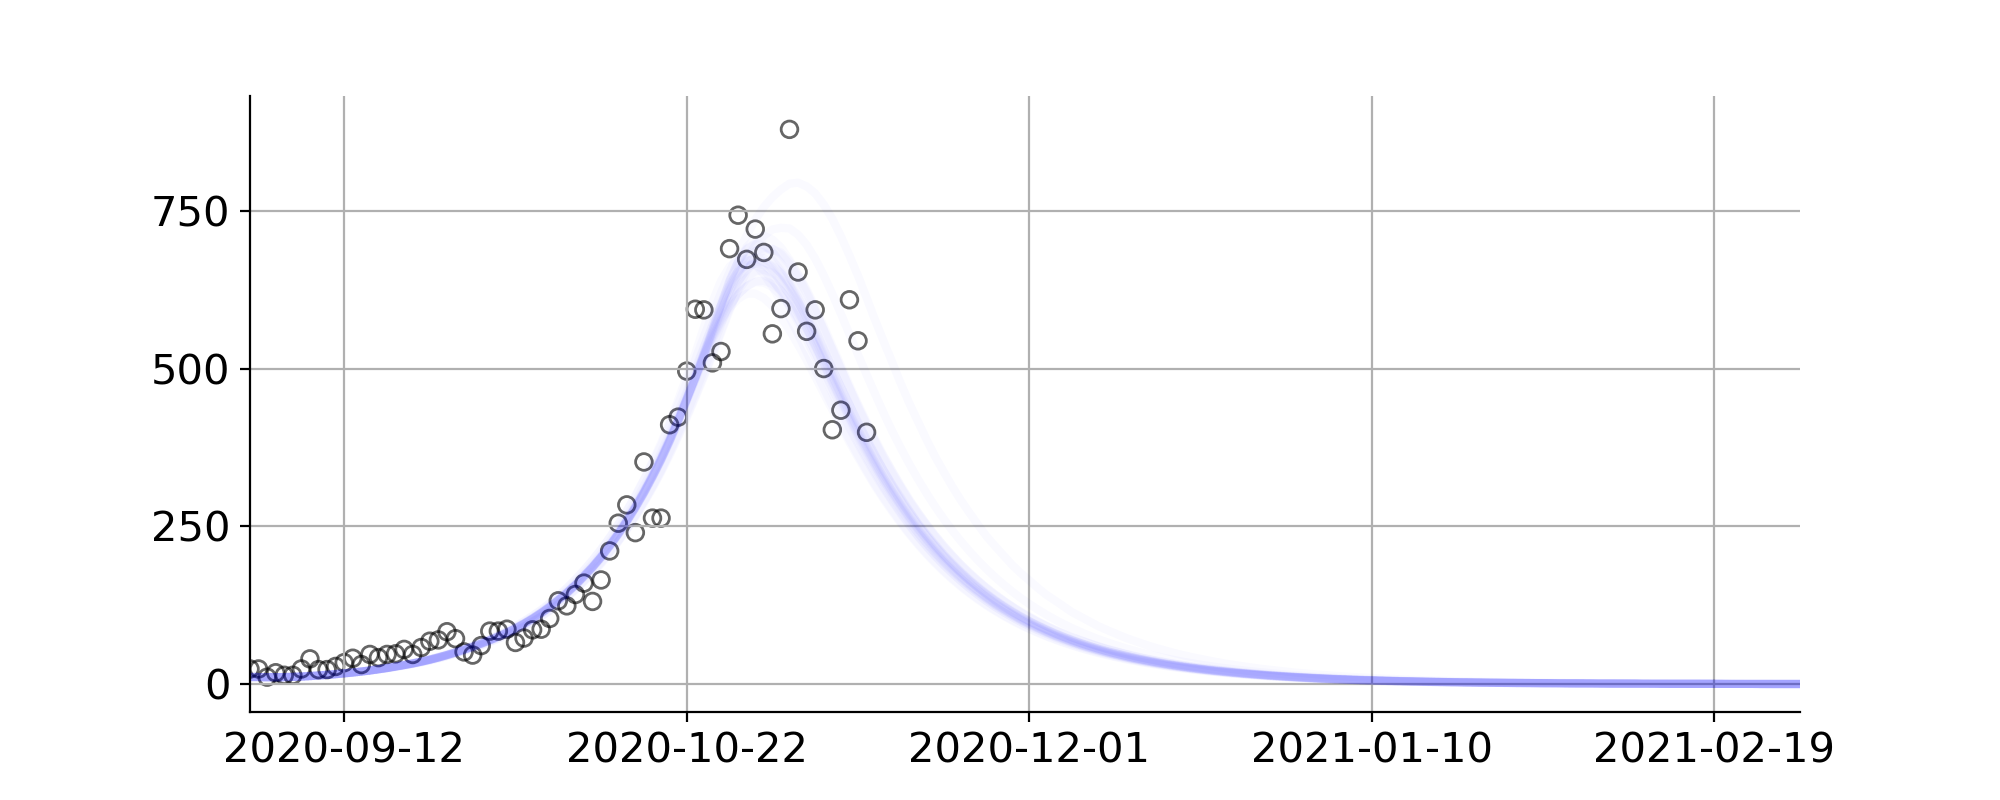

(737669.0, 737850.0)

In [12]:
end_sim = '2021-03-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(20):
    # Sampling
    model_S1.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model_S1.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model_S1.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model_S1['time'],y_model_S1["H_in"].sum(dim="Nc"),color='blue',alpha=0.02)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)

In [13]:
n=100
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

<IPython.core.display.Javascript object>


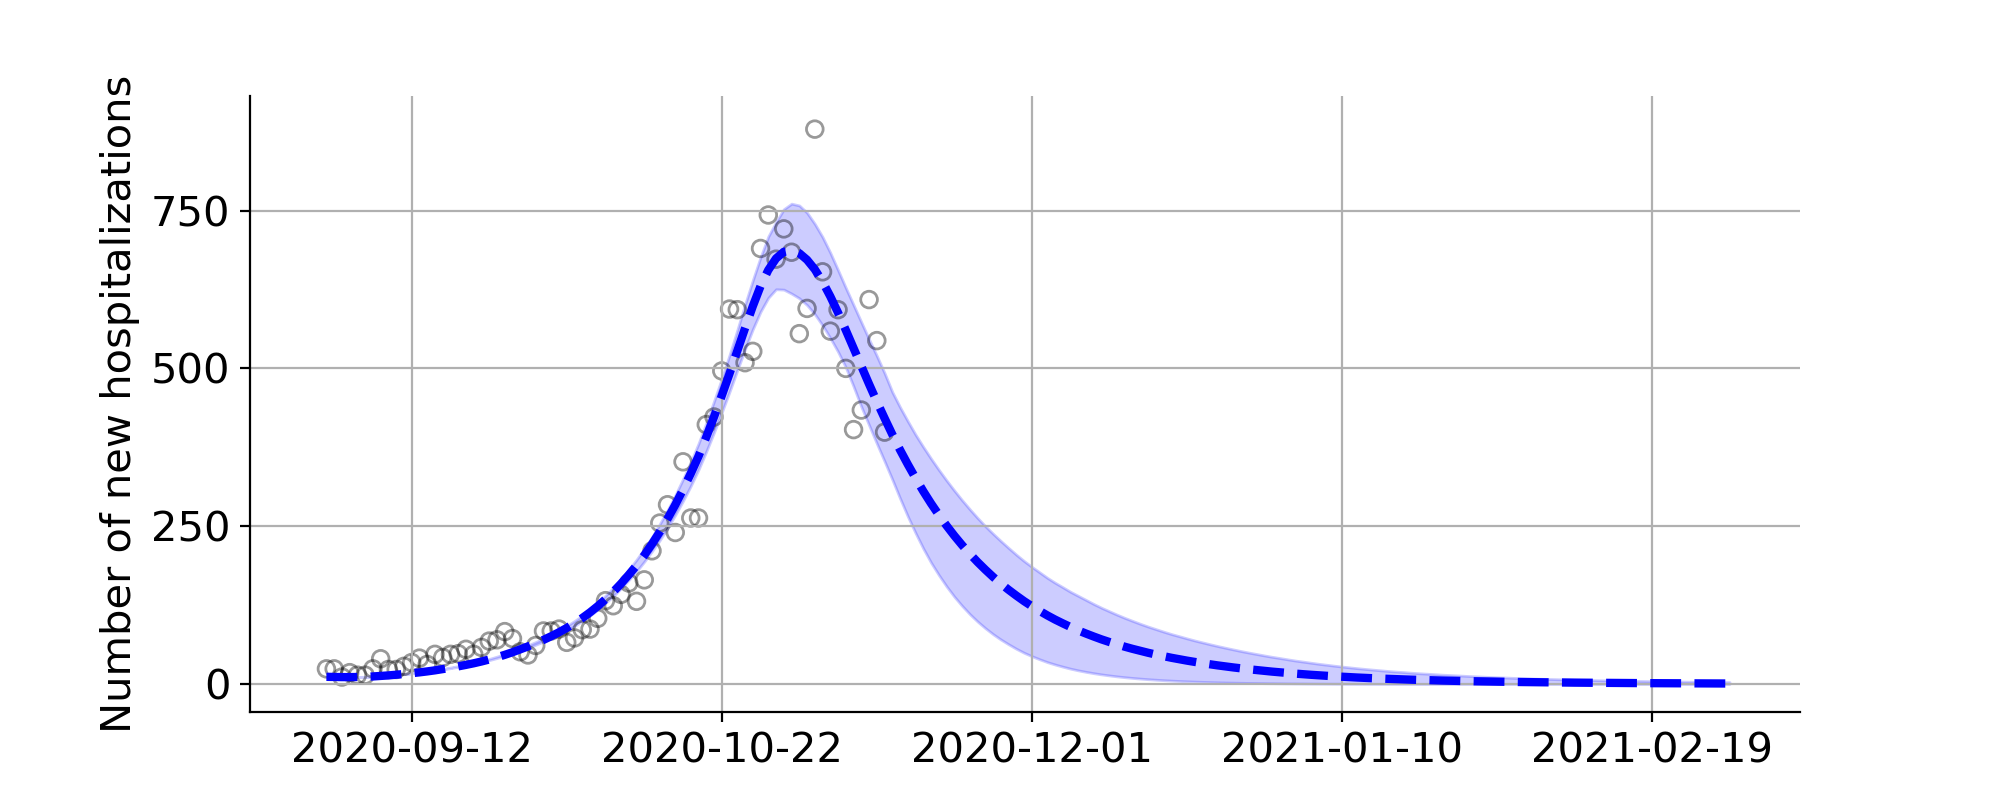

In [14]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

<IPython.core.display.Javascript object>


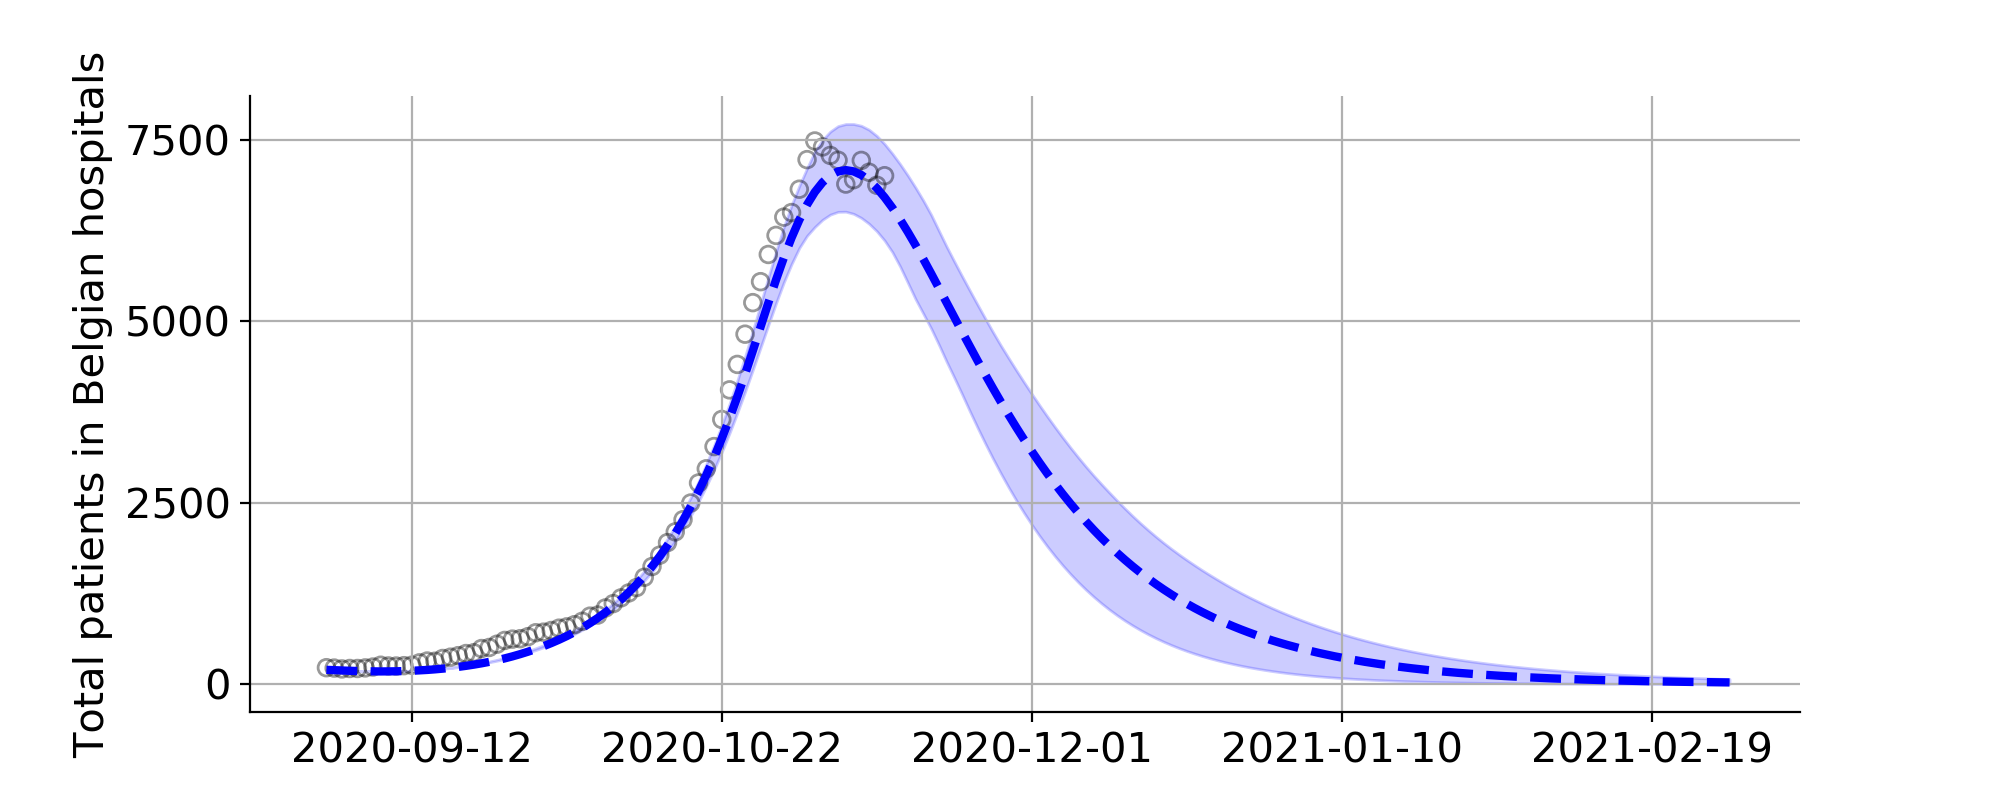

In [15]:

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_tot'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Total patients in Belgian hospitals')
ax = _apply_tick_locator(ax)

# Scenario 2: full reopening December 13



full reopening = contacts/transmission situation similar as first half October

In [16]:
def reopen_full_13dec(t,states,param,df_google, Nc_all, Nc_15min, Nc_1hr, l , tau, prevention):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')
    
    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-13') # reopening
    t9 = pd.Timestamp('2020-12-18') # schools close
    t10 = pd.Timestamp('2021-01-04') # schools re-open

    # get mobility reductions
    if t < t1:
        return Nc_all['total']
    elif t1 < t <= df_google.index[-1]:
        row = -df_google[df_google.index == pd.Timestamp(t.date())]/100
    elif t > df_google.index[-1]:
        row=-df_google[df_google.index == df_google.index[-1]]/100
    
    work=(1-row['work'].values)[0]
    transport=(1-row['transport'].values)[0]
    leisure=(1-row['retail_recreation'].values)[0]
    others=(1-row['grocery'].values)[0]
    
    mobility_first_half_oct = -df_google['2020-10-01':'2020-10-18'].mean()/100
    work_fho=1-mobility_first_half_oct['work']
    transport_fho=1-mobility_first_half_oct['transport']
    leisure_fho=1-mobility_first_half_oct['retail_recreation']
    others_fho=1-mobility_first_half_oct['grocery']
    
    # define policies
    if t5 < t <= t6 + tau_days:
        school = 1
        return (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        school = 1
        policy_old = (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
        policy_new = prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + 0*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        school = 0
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t7 < t <= t8:
        school = 1
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t8 < t <= t9:
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    elif t9 < t <= t10:
        school = 0
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    else:
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])



In [17]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

# Initialize the model
model_S2 = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': reopen_full_13dec})

In [18]:
n=100
y_model_S2 = model_S2.sim(end_sim,start_date=start_calibration,warmup=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

<IPython.core.display.Javascript object>


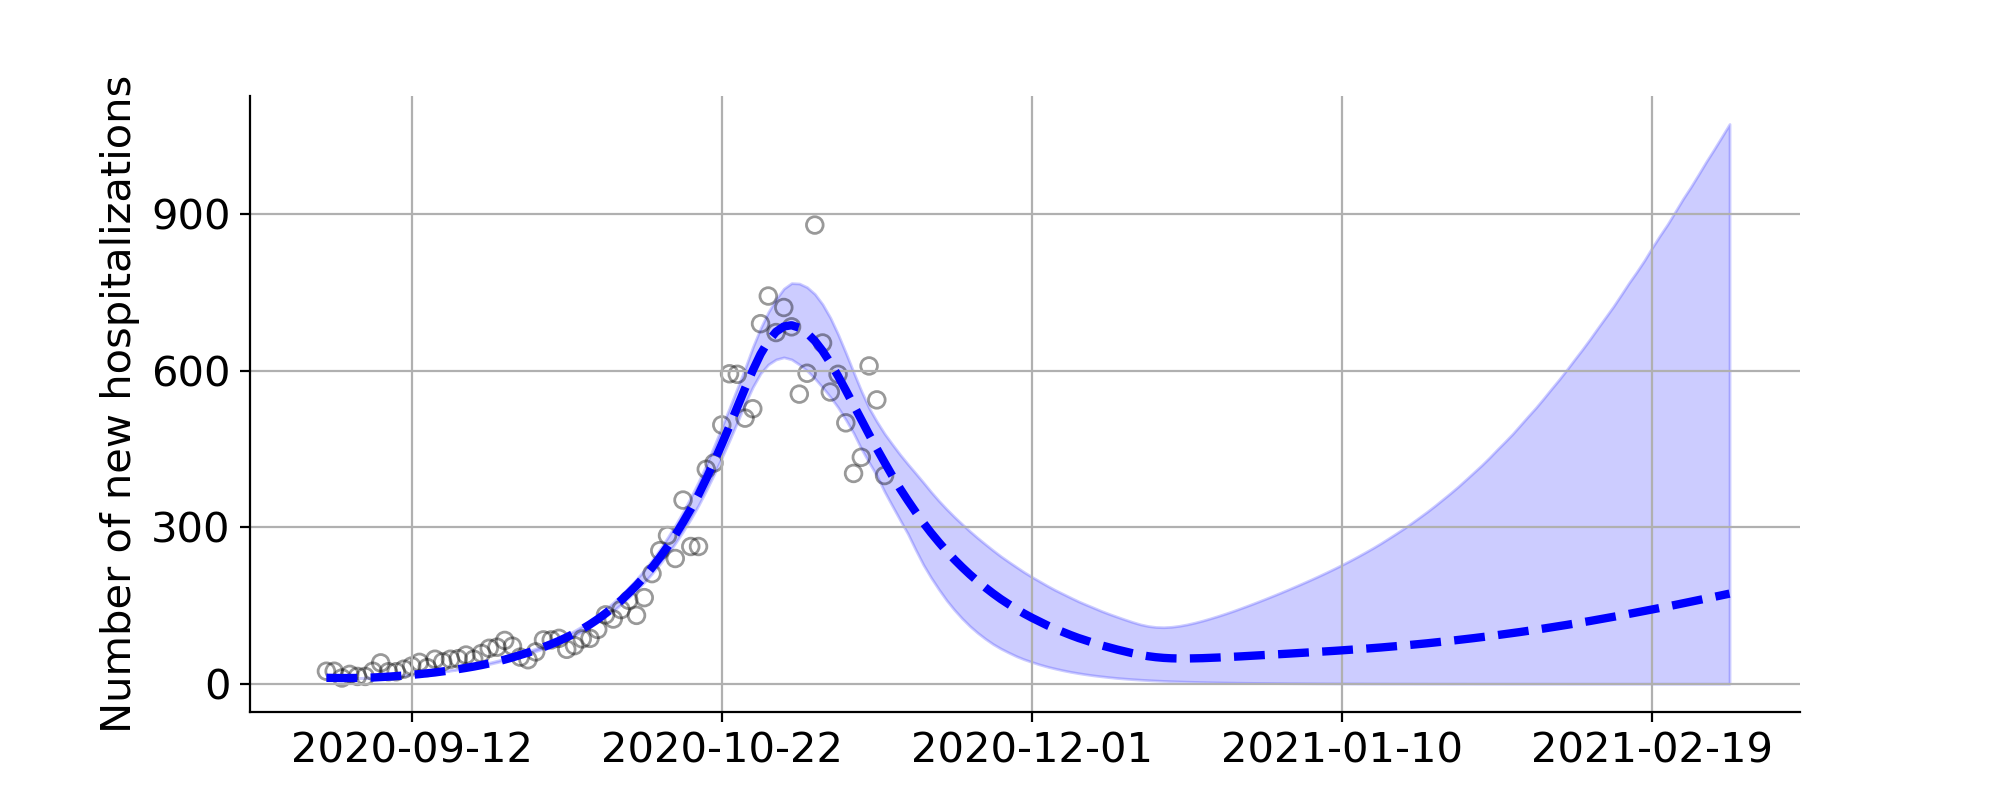

In [19]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S2['time'].values),y_model_S2["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S2["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S2['time'],y_model_S2["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

# Scenario 3: partial reopening November 30

partial reopening = 50% of contacts/transmission situation similar as first half October

In [20]:
def reopen_half_30Nov(t,states,param,df_google, Nc_all, Nc_15min, Nc_1hr, l , tau, prevention):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-11-30') # full reopening
    t9 = pd.Timestamp('2020-12-18') # schools close
    t10 = pd.Timestamp('2021-01-04') # schools re-open

    # get mobility reductions
    if t < t1:
        return Nc_all['total']
    elif t1 < t <= df_google.index[-1]:
        row = -df_google[df_google.index == pd.Timestamp(t.date())]/100
    elif t > df_google.index[-1]:
        row=-df_google[df_google.index == df_google.index[-1]]/100
    
    work=(1-row['work'].values)[0]
    transport=(1-row['transport'].values)[0]
    leisure=(1-row['retail_recreation'].values)[0]
    others=(1-row['grocery'].values)[0]
    
    half_mobility_reduction_first_half_oct = -df_google['2020-10-01':'2020-10-18'].mean()/100*2
    work_fho=1-half_mobility_reduction_first_half_oct['work']
    transport_fho=1-half_mobility_reduction_first_half_oct['transport']
    leisure_fho=1-half_mobility_reduction_first_half_oct['retail_recreation']
    others_fho=1-half_mobility_reduction_first_half_oct['grocery']
    
    # define policies
    if t5 < t <= t6 + tau_days:
        school = 1
        return (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        school = 1
        policy_old = (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
        policy_new = prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + 0*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        school = 0
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t7 < t <= t8:
        school = 1
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t8 < t <= t9: # full reopening
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    elif t9 < t <= t10: # schools close, rest fully open
        school = 0
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    else: # schools open after christmas
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])



In [21]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

# Initialize the model
model_S3 = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': reopen_half_30Nov})

<IPython.core.display.Javascript object>


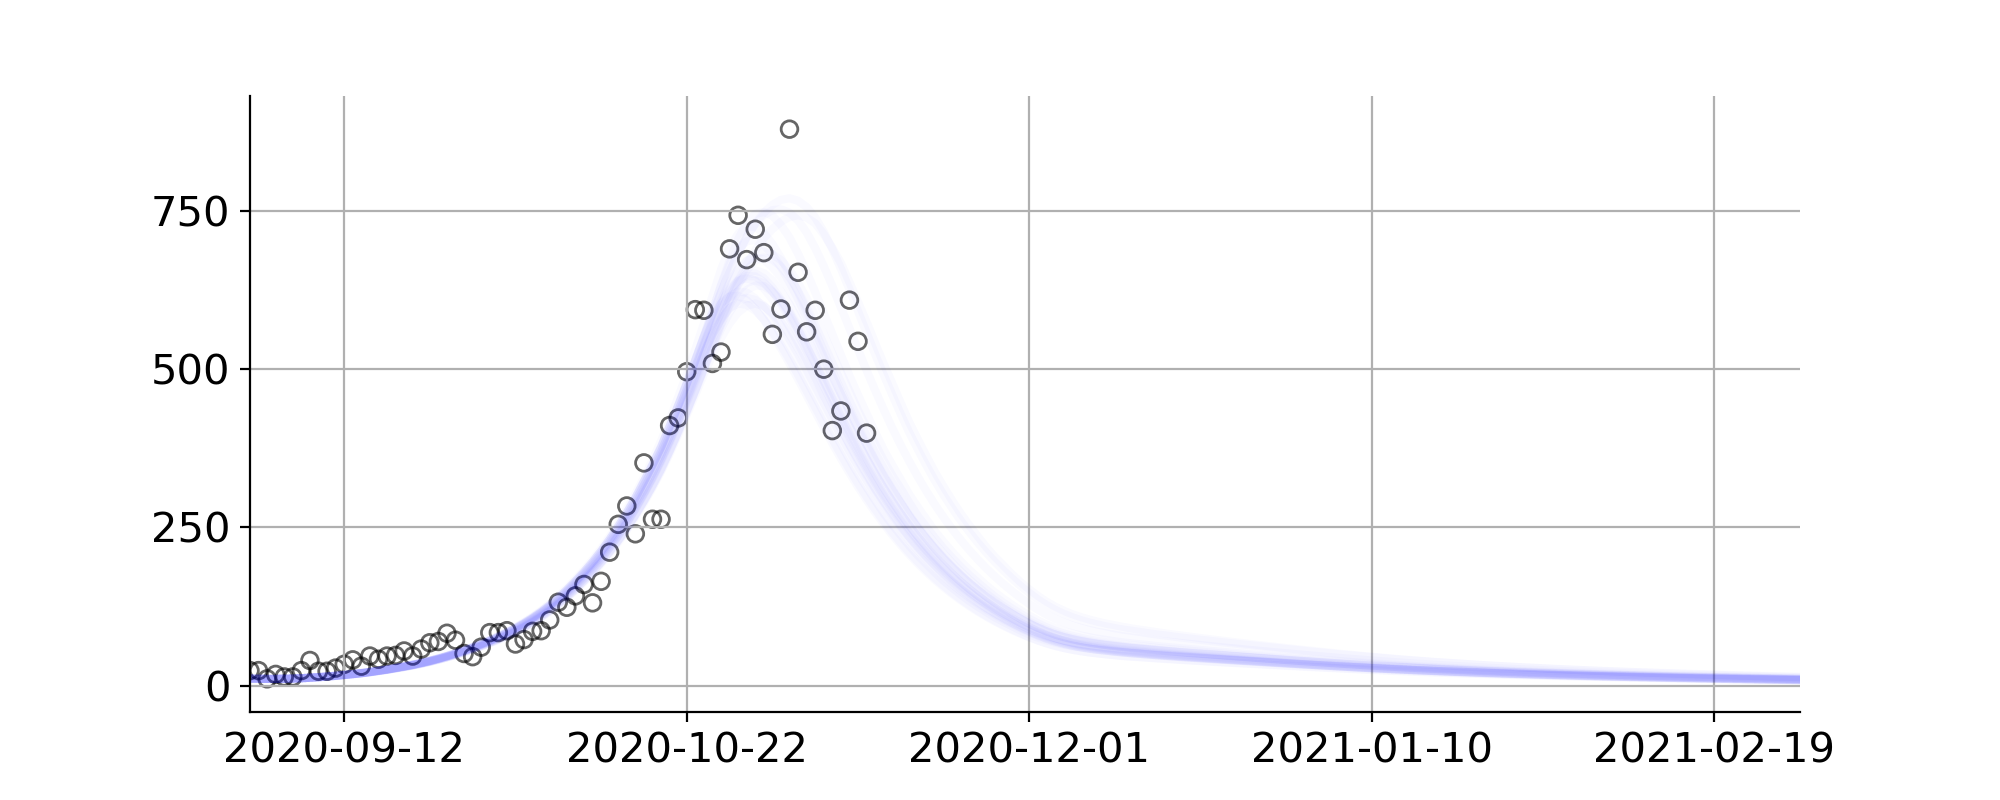

(737669.0, 737850.0)

In [22]:

fig,ax=plt.subplots(figsize=(10,4))
for i in range(20):
    # Sampling
    model_S3.parameters['beta'] = np.random.choice(samples_dict['beta'])
    idx,model_S3.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model_S3.parameters['tau'] = samples_dict['tau'][idx]   
    # Simulate
    y_model_S3 = model_S3.sim(end_sim,start_date=start_calibration,warmup=0)
    # Plot
    ax.plot(y_model_S3['time'],y_model_S3["H_in"].sum(dim="Nc"),color='blue',alpha=0.02)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)

In [23]:
n=100
y_model_S3 = model_S3.sim(end_sim,start_date=start_calibration,warmup=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

<IPython.core.display.Javascript object>


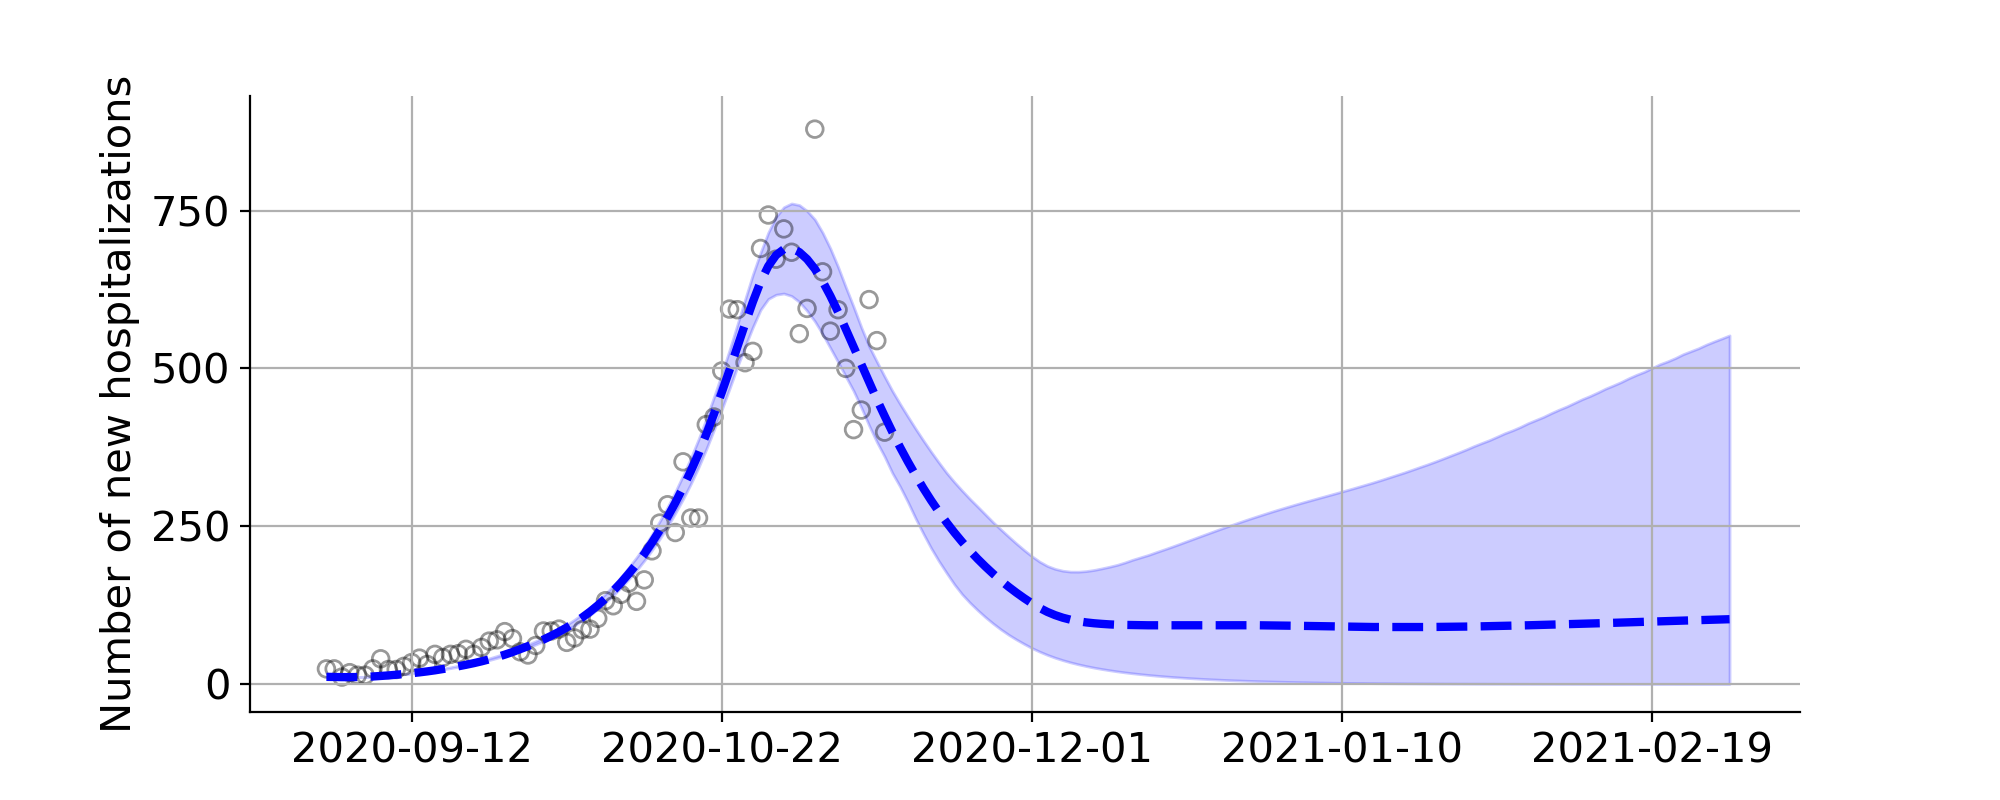

In [24]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S3['time'].values),y_model_S3["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S3["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S3['time'],y_model_S3["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

# Scenario 4: full reopening November 30


In [25]:
def reopen_full_30Nov(t,states,param,df_google, Nc_all, Nc_15min, Nc_1hr, l , tau, prevention):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-11-30') # full reopening
    t9 = pd.Timestamp('2020-12-18') # schools close
    t10 = pd.Timestamp('2021-01-04') # schools re-open

    # get mobility reductions
    if t < t1:
        return Nc_all['total']
    elif t1 < t <= df_google.index[-1]:
        row = -df_google[df_google.index == pd.Timestamp(t.date())]/100
    elif t > df_google.index[-1]:
        row=-df_google[df_google.index == df_google.index[-1]]/100
    
    work=(1-row['work'].values)[0]
    transport=(1-row['transport'].values)[0]
    leisure=(1-row['retail_recreation'].values)[0]
    others=(1-row['grocery'].values)[0]
    
    mobility_first_half_oct = -df_google['2020-10-01':'2020-10-18'].mean()/100
    work_fho=1-mobility_first_half_oct['work']
    transport_fho=1-mobility_first_half_oct['transport']
    leisure_fho=1-mobility_first_half_oct['retail_recreation']
    others_fho=1-mobility_first_half_oct['grocery']
    
    # define policies
    if t5 < t <= t6 + tau_days:
        school = 1
        return (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        school = 1
        policy_old = (1/2.3)*Nc_15min['home'] + work*Nc_15min['work'] + school*Nc_15min['schools'] + transport*Nc_15min['transport'] + leisure*Nc_15min['leisure'] + others*Nc_15min['others']
        policy_new = prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + 0*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        school = 0
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t7 < t <= t8:
        school = 1
        return prevention*((1/2.3)*Nc_1hr['home'] + work*Nc_1hr['work'] + school*Nc_1hr['schools'] + transport*Nc_1hr['transport'] + leisure*Nc_1hr['leisure'] + others*Nc_1hr['others'])
    elif t8 < t <= t9: # full reopening
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    elif t9 < t <= t10: # schools close, rest fully open
        school = 0
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])
    else: # schools open after christmas
        school = 1
        return prevention*((1/2.3)*Nc_15min['home'] + work_fho*Nc_15min['work'] + school*Nc_15min['schools'] + transport_fho*Nc_15min['transport'] + leisure_fho*Nc_15min['leisure'] + others_fho*Nc_15min['others'])



In [26]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

# Initialize the model
model_S4 = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': reopen_full_30Nov})

In [27]:
n=100
y_model_S4 = model_S4.sim(end_sim,start_date=start_calibration,warmup=0,N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

<IPython.core.display.Javascript object>


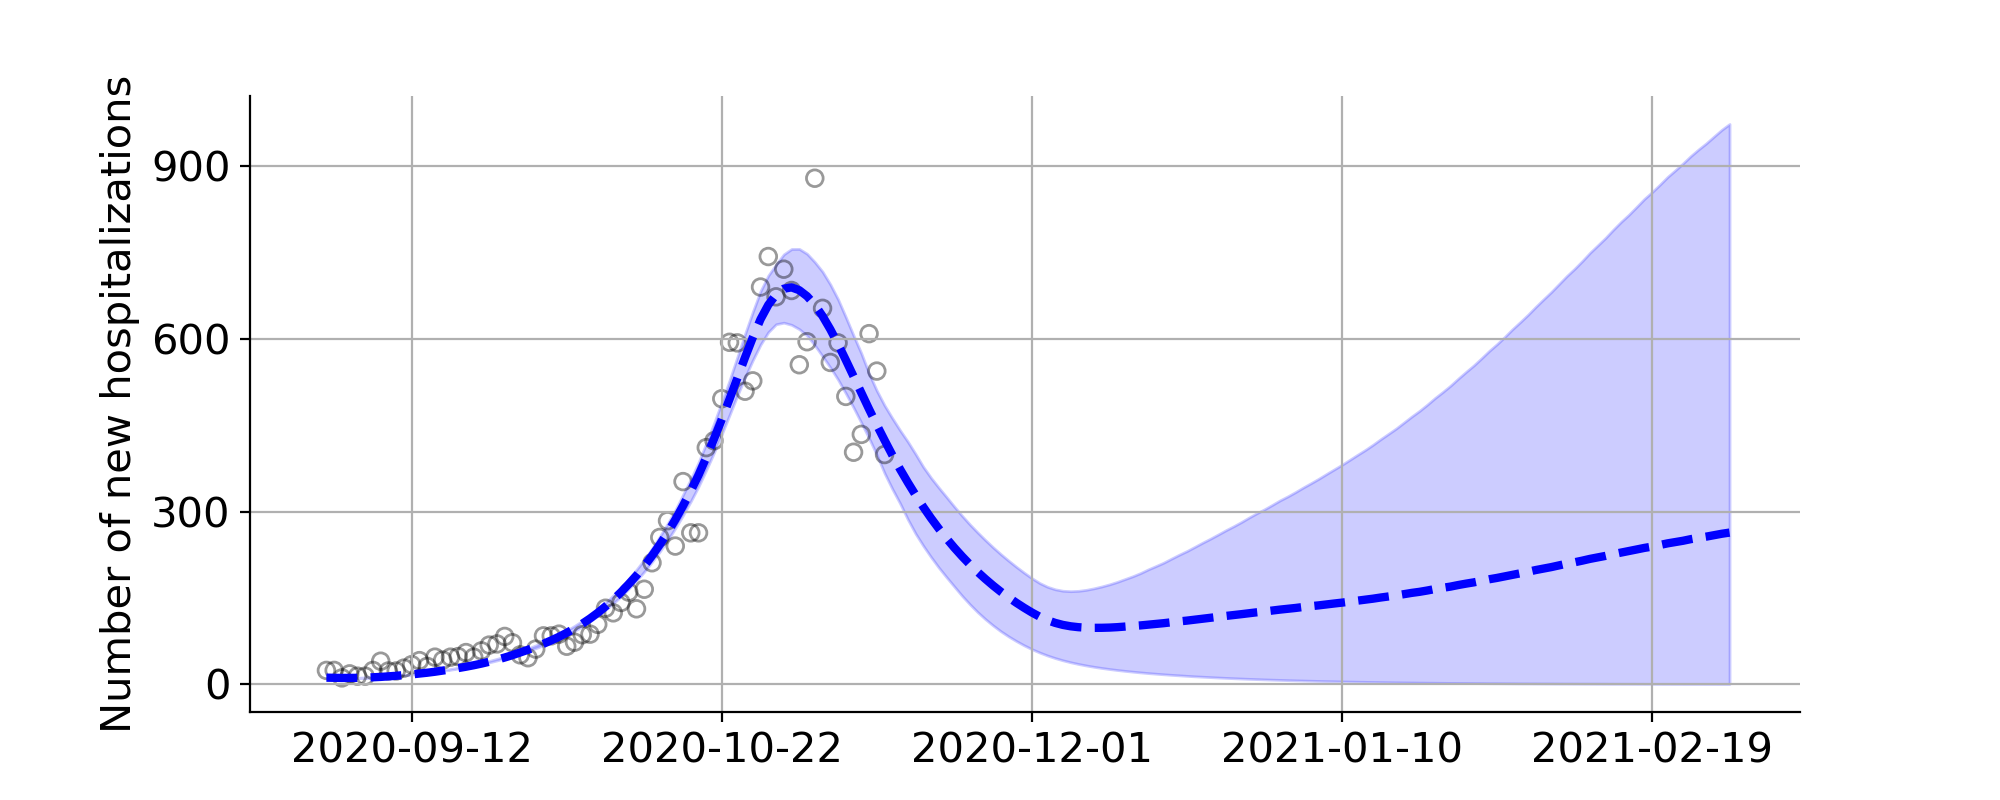

In [28]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S4['time'].values),y_model_S4["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S4["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S4['time'],y_model_S4["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

# Write out data

In [48]:
columns = ['Date', 'S1_incidences_mean','S1_incidences_median','S1_incidences_LL','S1_incidences_UL','S1_load_mean','S1_load_LL','S1_load_UL','S2_incidences_mean','S2_incidences_median','S2_incidences_LL','S2_incidences_UL','S2_load_mean','S2_load_LL','S2_load_UL','S3_incidences_mean','S3_incidences_median','S3_incidences_LL','S3_incidences_UL','S3_load_mean','S3_load_LL','S3_load_UL','S4_incidences_mean','S4_incidences_median','S4_incidences_LL','S4_incidences_UL','S4_load_mean','S4_load_LL','S4_load_UL']

In [49]:
results = pd.DataFrame(columns=columns)

In [50]:
results['Date'] = y_model_S1['time']

In [51]:
S1_incidences = y_model_S1["H_in"].sum(dim="Nc")
results['S1_incidences_mean'] = S1_incidences.mean(dim="draws").values
results['S1_incidences_median'] = S1_incidences.median(dim="draws").values
results['S1_incidences_LL'] = S1_incidences.quantile(LL,dim="draws").values
results['S1_incidences_UL'] = S1_incidences.quantile(UL,dim="draws").values
S1_load = y_model_S1["H_tot"].sum(dim="Nc")
results['S1_load_mean'] = S1_load.mean(dim="draws").values
results['S1_load_median'] = S1_load.median(dim="draws").values
results['S1_load_LL'] = S1_load.quantile(LL,dim="draws").values
results['S1_load_UL'] = S1_load.quantile(UL,dim="draws").values

In [52]:
S2_incidences = y_model_S2["H_in"].sum(dim="Nc")
results['S2_incidences_mean'] = S2_incidences.mean(dim="draws").values
results['S2_incidences_median'] = S2_incidences.median(dim="draws").values
results['S2_incidences_LL'] = S2_incidences.quantile(LL,dim="draws").values
results['S2_incidences_UL'] = S2_incidences.quantile(UL,dim="draws").values
S2_load = y_model_S2["H_tot"].sum(dim="Nc")
results['S2_load_mean'] = S2_load.mean(dim="draws").values
results['S2_load_median'] = S2_load.median(dim="draws").values
results['S2_load_LL'] = S2_load.quantile(LL,dim="draws").values
results['S2_load_UL'] = S2_load.quantile(UL,dim="draws").values

In [53]:
S3_incidences = y_model_S3["H_in"].sum(dim="Nc")
results['S3_incidences_mean'] = S3_incidences.mean(dim="draws").values
results['S3_incidences_median'] = S3_incidences.median(dim="draws").values
results['S3_incidences_LL'] = S3_incidences.quantile(LL,dim="draws").values
results['S3_incidences_UL'] = S3_incidences.quantile(UL,dim="draws").values
S3_load = y_model_S3["H_tot"].sum(dim="Nc")
results['S3_load_mean'] = S3_load.mean(dim="draws").values
results['S3_load_median'] = S3_load.median(dim="draws").values
results['S3_load_LL'] = S3_load.quantile(LL,dim="draws").values
results['S3_load_UL'] = S3_load.quantile(UL,dim="draws").values

In [54]:
S4_incidences = y_model_S4["H_in"].sum(dim="Nc")
results['S4_incidences_mean'] = S4_incidences.mean(dim="draws").values
results['S4_incidences_median'] = S4_incidences.median(dim="draws").values
results['S4_incidences_LL'] = S4_incidences.quantile(LL,dim="draws").values
results['S4_incidences_UL'] = S4_incidences.quantile(UL,dim="draws").values
S4_load = y_model_S4["H_tot"].sum(dim="Nc")
results['S4_load_mean'] = S4_load.mean(dim="draws").values
results['S4_load_median'] = S4_load.median(dim="draws").values
results['S4_load_LL'] = S4_load.quantile(LL,dim="draws").values
results['S4_load_UL'] = S4_load.quantile(UL,dim="draws").values

In [55]:
results

,Date,S1_incidences_mean,S1_incidences_median,S1_incidences_LL,S1_incidences_UL,S1_load_mean,S1_load_LL,S1_load_UL,S2_incidences_mean,S2_incidences_median,...,S4_incidences_median,S4_incidences_LL,S4_incidences_UL,S4_load_mean,S4_load_LL,S4_load_UL,S1_load_median,S2_load_median,S3_load_median,S4_load_median
0,2020-09-01,11.367041,11.367041,11.367041,11.367041,196.649748,196.649748,196.649748,11.367041,11.367041,...,11.367041,11.367041,11.367041,196.649748,196.649748,196.649748,196.649748,196.649748,196.649748,196.649748
1,2020-09-02,11.083842,11.083840,11.083774,11.083901,191.855628,191.855485,191.855747,11.083925,11.083857,...,11.083888,11.081659,11.084687,191.855635,191.854952,191.855995,191.855626,191.855653,191.855570,191.855640
2,2020-09-03,10.922366,10.922345,10.920514,10.923905,187.307677,187.305336,187.309631,10.922258,10.922127,...,10.922264,10.920441,10.925120,187.307725,187.305717,187.310153,187.307649,187.307531,187.307632,187.307613
3,2020-09-04,10.896814,10.896747,10.891232,10.901482,183.177320,183.167699,183.185361,10.896309,10.896144,...,10.896589,10.892283,10.902516,183.177582,183.169481,183.187303,183.177203,183.176292,183.176738,183.177114
4,2020-09-05,11.061935,11.061774,11.048669,11.073028,179.663164,179.637072,179.684975,11.060941,11.060096,...,11.061481,11.050994,11.075179,179.663994,179.642053,179.689534,179.662849,179.659866,179.662639,179.661922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2021-02-25,0.954973,0.688594,0.002050,3.482145,28.123917,1.590442,82.788104,160.213960,61.248613,...,147.114299,0.465937,929.096643,2976.038239,13.412132,10463.021746,23.381310,757.805691,658.036461,1826.217477
178,2021-02-26,0.909320,0.649817,0.001830,3.354235,26.672117,1.461972,79.248922,163.367694,61.598684,...,147.583282,0.445983,939.800636,3009.109584,12.735197,10624.915297,22.055014,761.802889,653.372140,1834.851048
179,2021-02-27,0.865545,0.614181,0.001649,3.204591,25.298691,1.343992,75.868723,166.444540,61.944197,...,148.322912,0.423761,951.658077,3041.874153,12.094102,10785.244917,20.805216,765.842170,648.768751,1843.496951
180,2021-02-28,0.823109,0.580593,0.001450,3.074263,23.999228,1.235640,72.639953,169.566724,62.285946,...,149.101492,0.403667,963.273778,3074.294788,11.486837,10943.786963,19.627432,769.921254,644.223665,1852.149979


In [57]:
results.to_csv('../results/predictions/FAGG/UGent_2020-11-14-with-prev.csv')